<a href="https://colab.research.google.com/github/linhhvo/machine-learning-assignments/blob/master/rnn/LinhVo_HW5_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, LSTM, Dropout, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import re
import string
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

path = "/content/drive/My Drive/CS733-HW5/" 
os.chdir(path)

dataset_orig = pd.read_csv("Tweets.csv")
dataset_orig.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.700000e+17,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/2015 11:35,NaN,Eastern Time (US & Canada)
1,5.700000e+17,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/2015 11:15,NaN,Pacific Time (US & Canada)
2,5.700000e+17,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2/24/2015 11:15,Lets Play,Central Time (US & Canada)
3,5.700000e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2/24/2015 11:15,NaN,Pacific Time (US & Canada)
4,5.700000e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2/24/2015 11:14,NaN,Pacific Time (US & Canada)


In [ ]:
# Keep only relevant columns
dataset = dataset_orig[['airline_sentiment', 'text']]

# Drop rows with 'neutral' sentiment
dataset = dataset[dataset['airline_sentiment'] != 'neutral']

# Add 'polarity' column and set value to be 1 if sentiment is positive and 0 otherwise
dataset['polarity'] = np.where(dataset['airline_sentiment'] == 'positive', 1, 0)

print(dataset.shape)
dataset.head()

(11541, 3)


,airline_sentiment,text,polarity
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [ ]:
# Only keep 'text' and 'polarity' columns to train model
df = dataset[['text', 'polarity']]

pd.options.display.max_colwidth = 10000
df

,text,polarity
1,@VirginAmerica plus you've added commercials to the experience... tacky.,1
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
4,@VirginAmerica and it's a really big bad thing about it,0
5,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,0
6,"@VirginAmerica yes, nearly every time I fly VX this â€œear wormâ€ wonâ€™t go away :)",1
...,...,...
14633,"@AmericanAir my flight was Cancelled Flightled, leaving tomorrow morning. Auto rebooked for a Tuesday night flight but need to arrive Monday.",0
14634,@AmericanAir right on cue with the delaysðŸ‘Œ,0
14635,@AmericanAir thank you we got on a different flight to Chicago.,1
14636,@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc,0


# Part 1

### Preprocessing dataset

In [ ]:
# Create a custom standardization function .
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    return tf.strings.regex_replace(lowercase,'[%s]' % re.escape(string.punctuation), '')

# Vocabulary size and number of words in a sequence.
vocab_size = 10000
sequence_length = 100

# Use the text vectorization layer to normalize, split, and map strings to 
# integers. Note that the layer uses the custom standardization defined above. 
# Set maximum_sequence length as all samples are not of the same length.
vectorization_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_dataset = df['text'].to_numpy()
vectorization_layer.adapt(text_dataset)

In [ ]:
vocab = np.array(vectorization_layer.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'to', 'the', 'i', 'a', 'united', 'you', 'for',
       'flight', 'and', 'on', 'my', 'usairways', 'americanair', 'is',
       'in', 'southwestair', 'of', 'jetblue'], dtype='<U160')

In [ ]:
print(df.iloc[1, 0])
encoded_review = vectorization_layer(df.text)
print(encoded_review[2].numpy())
print(f"\nIndex 69 refers to the word '{vocab[69]}'")
print(f"\nIndex 10 refers to the word '{vocab[10]}'")

@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
[100  10  69   5 120 435 193 475  86  22   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]

Index 69 refers to the word 'its'

Index 10 refers to the word 'and'


In [ ]:
# Split data into training and testing sets
train_dataset, test_dataset = train_test_split(df, test_size=0.2, random_state=15)

train_text = train_dataset.text.to_numpy()
train_label = train_dataset.polarity.to_numpy()
test_text = test_dataset.text.to_numpy()
test_label= test_dataset.polarity.to_numpy()

### Train and evaluate model 1

In [ ]:
np.random.seed(15)
tf.random.set_seed(15)

embedding_dim = 64

model_1 = tf.keras.Sequential([
    vectorization_layer,
    Embedding(vocab_size, embedding_dim, mask_zero=True),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
])

In [ ]:
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 100)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 64)           640000    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 100, 256)          197632    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)               

In [ ]:
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='sgd',
              metrics=['accuracy'])

In [ ]:
history = model_1.fit(x=train_text, y=train_label, epochs=40, validation_split=0.1)

Epoch 1/40
260/260 [==============================] - 56s 39ms/step - loss: 0.5873 - accuracy: 0.7883 - val_loss: 0.5133 - val_accuracy: 0.7792
Epoch 2/40
260/260 [==============================] - 6s 24ms/step - loss: 0.4982 - accuracy: 0.7954 - val_loss: 0.5095 - val_accuracy: 0.7792
Epoch 3/40
260/260 [==============================] - 6s 25ms/step - loss: 0.4956 - accuracy: 0.7927 - val_loss: 0.5044 - val_accuracy: 0.7792
Epoch 4/40
260/260 [==============================] - 6s 24ms/step - loss: 0.4795 - accuracy: 0.7974 - val_loss: 0.4964 - val_accuracy: 0.7792
Epoch 5/40
260/260 [==============================] - 6s 25ms/step - loss: 0.4766 - accuracy: 0.7956 - val_loss: 0.4887 - val_accuracy: 0.7792
Epoch 6/40
260/260 [==============================] - 6s 24ms/step - loss: 0.4813 - accuracy: 0.7879 - val_loss: 0.4810 - val_accuracy: 0.7792
Epoch 7/40
260/260 [==============================] - 6s 25ms/step - loss: 0.4633 - accuracy: 0.7967 - val_loss: 0.4723 - val_accuracy: 0.779

In [ ]:
train_loss, train_acc = model_1.evaluate(x=train_text, y=train_label, verbose=0)
print('Train Loss: {:.4f}'.format(train_loss))
print('Train Accuracy: {:.4f}'.format(train_acc))

print()

test_loss, test_acc = model_1.evaluate(x=test_text, y=test_label, verbose=0)
print('Test Loss: {:.4f}'.format(test_loss))
print('Test Accuracy: {:.4f}'.format(test_acc))

Train Loss: 0.1882
Train Accuracy: 0.9282

Test Loss: 0.2607
Test Accuracy: 0.9108


In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '') # for validation results
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

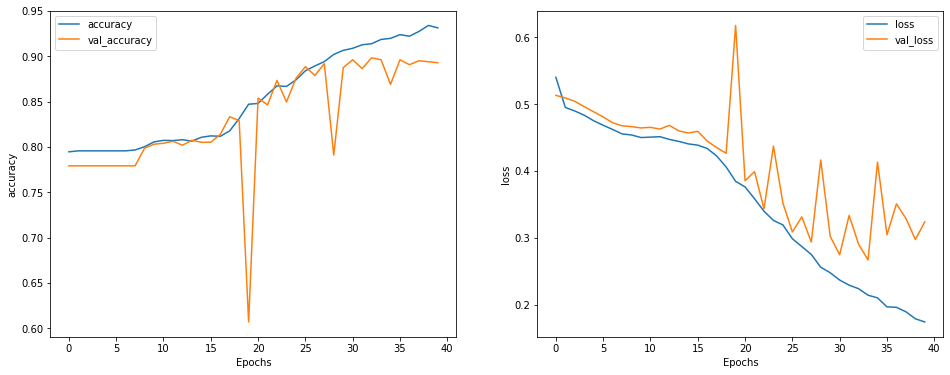

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# Part 2



### Preprocessing dataset

In [ ]:
# Make a copy of dataset
df_2 = df.copy()
df_2

,text,polarity
1,@VirginAmerica plus you've added commercials to the experience... tacky.,1
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
4,@VirginAmerica and it's a really big bad thing about it,0
5,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,0
6,"@VirginAmerica yes, nearly every time I fly VX this â€œear wormâ€ wonâ€™t go away :)",1
...,...,...
14633,"@AmericanAir my flight was Cancelled Flightled, leaving tomorrow morning. Auto rebooked for a Tuesday night flight but need to arrive Monday.",0
14634,@AmericanAir right on cue with the delaysðŸ‘Œ,0
14635,@AmericanAir thank you we got on a different flight to Chicago.,1
14636,@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc,0


In [ ]:
# Convert each tweet into a list of words
df_2['text'] = df_2['text'].str.split()

# Remove stop words
nltk.download('stopwords')
stops = set(stopwords.words("english"))                  

def remove_stops(row):
    text = row['text']
    filtered_text = [word for word in text if not word in stops]
    return (filtered_text)

# Apply preprocessing functions to dataset and store values in separate columns
df_2['processed_text'] = df_2.apply(remove_stops, axis=1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df_2

,text,polarity,processed_text
1,"[@VirginAmerica, plus, you've, added, commercials, to, the, experience..., tacky.]",1,"[@VirginAmerica, plus, added, commercials, experience..., tacky.]"
3,"[@VirginAmerica, it's, really, aggressive, to, blast, obnoxious, ""entertainment"", in, your, guests', faces, &amp;, they, have, little, recourse]",0,"[@VirginAmerica, really, aggressive, blast, obnoxious, ""entertainment"", guests', faces, &amp;, little, recourse]"
4,"[@VirginAmerica, and, it's, a, really, big, bad, thing, about, it]",0,"[@VirginAmerica, really, big, bad, thing]"
5,"[@VirginAmerica, seriously, would, pay, $30, a, flight, for, seats, that, didn't, have, this, playing., it's, really, the, only, bad, thing, about, flying, VA]",0,"[@VirginAmerica, seriously, would, pay, $30, flight, seats, playing., really, bad, thing, flying, VA]"
6,"[@VirginAmerica, yes,, nearly, every, time, I, fly, VX, this, â€œear, wormâ€, wonâ€™t, go, away, :)]",1,"[@VirginAmerica, yes,, nearly, every, time, I, fly, VX, â€œear, wormâ€, wonâ€™t, go, away, :)]"
...,...,...,...
14633,"[@AmericanAir, my, flight, was, Cancelled, Flightled,, leaving, tomorrow, morning., Auto, rebooked, for, a, Tuesday, night, flight, but, need, to, arrive, Monday.]",0,"[@AmericanAir, flight, Cancelled, Flightled,, leaving, tomorrow, morning., Auto, rebooked, Tuesday, night, flight, need, arrive, Monday.]"
14634,"[@AmericanAir, right, on, cue, with, the, delaysðŸ‘Œ]",0,"[@AmericanAir, right, cue, delaysðŸ‘Œ]"
14635,"[@AmericanAir, thank, you, we, got, on, a, different, flight, to, Chicago.]",1,"[@AmericanAir, thank, got, different, flight, Chicago.]"
14636,"[@AmericanAir, leaving, over, 20, minutes, Late, Flight., No, warnings, or, communication, until, we, were, 15, minutes, Late, Flight., That's, called, shitty, customer, svc]",0,"[@AmericanAir, leaving, 20, minutes, Late, Flight., No, warnings, communication, 15, minutes, Late, Flight., That's, called, shitty, customer, svc]"


In [ ]:
# Join words back into sentences
def rejoin_words(row):
    text = row['processed_text']
    joined_words = ( " ".join(text))
    return joined_words

df_2['processed_text'] = df_2.apply(rejoin_words, axis=1) 

In [ ]:
# Drop unnecessary columns
df_2.drop(columns=['text'], inplace=True)
df_2

,polarity,processed_text
1,1,@VirginAmerica plus added commercials experience... tacky.
3,0,"@VirginAmerica really aggressive blast obnoxious ""entertainment"" guests' faces &amp; little recourse"
4,0,@VirginAmerica really big bad thing
5,0,@VirginAmerica seriously would pay $30 flight seats playing. really bad thing flying VA
6,1,"@VirginAmerica yes, nearly every time I fly VX â€œear wormâ€ wonâ€™t go away :)"
...,...,...
14633,0,"@AmericanAir flight Cancelled Flightled, leaving tomorrow morning. Auto rebooked Tuesday night flight need arrive Monday."
14634,0,@AmericanAir right cue delaysðŸ‘Œ
14635,1,@AmericanAir thank got different flight Chicago.
14636,0,@AmericanAir leaving 20 minutes Late Flight. No warnings communication 15 minutes Late Flight. That's called shitty customer svc


In [ ]:
# Create a custom standardization function to strip twitter usernames/handlers.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    removed_punctuation = tf.strings.regex_replace(lowercase,'[%s]' % re.escape(string.punctuation), '')
    removed_tweets_handle = tf.strings.regex_replace(removed_punctuation, '([@][\w_-]+)', '')
    return removed_tweets_handle

# Vocabulary size and number of words in a sequence.
vocab_size = 10000
sequence_length = 100

# Use the text vectorization layer to normalize, split, and map strings to 
# integers. Note that the layer uses the custom standardization defined above. 
# Set maximum_sequence length as all samples are not of the same length.
vectorization_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_dataset = df_2['processed_text'].to_numpy()
vectorization_layer.adapt(text_dataset)

In [ ]:
# Split data into training and testing sets
train_dataset_2, test_dataset_2 = train_test_split(df_2, test_size=0.2, random_state=15)

train_text_2 = train_dataset_2.processed_text.to_numpy()
train_label_2 = train_dataset_2.polarity.to_numpy()
test_text_2 = test_dataset_2.processed_text.to_numpy()
test_label_2= test_dataset_2.polarity.to_numpy()

### Train and evaluate model 2

In [ ]:
from tensorflow.keras.regularizers import l1, l2, l1_l2

In [ ]:
np.random.seed(112)
tf.random.set_seed(20)

embedding_dim = 64

model_2 = tf.keras.Sequential([
    vectorization_layer,
    Embedding(vocab_size, embedding_dim, mask_zero=True),
    Bidirectional(LSTM(16)),
    BatchNormalization(),
    Dense(32, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

In [ ]:
# Add learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.01,
    decay_steps=100000,
    decay_rate=0.95,
    staircase=True)

model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              metrics=['accuracy'])

In [ ]:
earlystopper = EarlyStopping(
    patience=20,
    restore_best_weights=True,
    verbose=1)

history_2 = model_2.fit(
    x=train_text_2, 
    y=train_label_2, 
    batch_size= 100,
    epochs=40, 
    validation_split=0.1,
    callbacks=[earlystopper],
    verbose=0
    )

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping


In [ ]:
train_loss, train_acc = model_2.evaluate(x=train_text_2, y=train_label_2, verbose=0)

print('Train Loss: {:.4f}'.format(train_loss))
print('Train Accuracy: {:.4f}'.format(train_acc))

print()
test_loss, test_acc = model_2.evaluate(x=test_text_2, y=test_label_2, verbose=0)

print('Test Loss: {:.4f}'.format(test_loss))
print('Test Accuracy: {:.4f}'.format(test_acc))

Train Loss: 0.0727
Train Accuracy: 0.9829

Test Loss: 0.2973
Test Accuracy: 0.9142


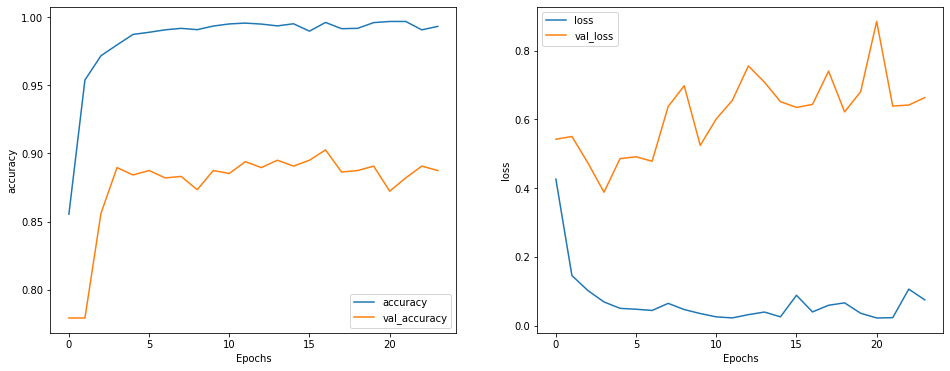

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history_2, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history_2, 'loss')